In [1]:
import matplotlib.pyplot as plt
import numpy as np
from custom_sepsis import *

/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
param_grid = {
    "buffer_size": [50000, 100000],  # Smaller buffers reduce memory usage but still retain sufficient experience for learning.
    "batch_size": [16, 32],         # Smaller batch sizes allow for quicker updates and more frequent learning.
    "train_freq": [1, 2],           # More frequent training (every step or every 2 steps) ensures faster feedback from collected samples.
    "gradient_steps": [1, 4, 8],    # Multiple gradient updates per step to make the most of each sample.
    "exploration_fraction": [0.1, 0.3],  # Larger fractions encourage exploration early, crucial for sparse environments.
    "exploration_final_eps": [0.01, 0.05],  # Lower final exploration rate ensures exploitation once sufficient samples are collected.
    "target_update_interval": [500, 1000],  # Target updates spaced out to allow the policy to stabilize between updates.
}

# Create a grid of all parameter combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Convert parameter combinations to dictionaries
param_dicts = [dict(zip(param_names, values)) for values in param_combinations]



In [3]:
with Pool(cpu_count()) as pool:
    results = pool.map(train_and_log_rewards, param_dicts)


/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: Us

In [6]:
import pandas as pd
# Analyze results
results_df = pd.DataFrame([
    {
        "params": res[0],
        "sample_efficiency": np.argmax(np.array(res[1]) >= -0.5) if np.any(np.array(res[1]) >= -0.5) else float('inf'),
        "asymptotic_rewards": np.mean(res[1][-100:]),
        "cumulative_rewards": np.sum(res[1]),
    }
    for res in results
])

# Normalize scores and rank
results_df["sample_efficiency_score"] = 1 / results_df["sample_efficiency"]  # Lower is better
results_df["asymptotic_rewards_score"] = results_df["asymptotic_rewards"]
results_df["cumulative_rewards_score"] = results_df["cumulative_rewards"]

# Extract best parameters for each goal
best_sample_efficiency = results_df.iloc[results_df["sample_efficiency_score"].idxmax()]["params"]
best_asymptotic_rewards = results_df.iloc[results_df["asymptotic_rewards_score"].idxmax()]["params"]
best_cumulative_rewards = results_df.iloc[results_df["cumulative_rewards_score"].idxmax()]["params"]

# Print results
print("Best parameters for sample efficiency:", best_sample_efficiency)
print("Best parameters for asymptotic rewards:", best_asymptotic_rewards)
print("Best parameters for cumulative rewards:", best_cumulative_rewards)


Best parameters for sample efficiency: {'buffer_size': 50000, 'batch_size': 16, 'train_freq': 1, 'gradient_steps': 1, 'exploration_fraction': 0.1, 'exploration_final_eps': 0.05, 'target_update_interval': 1000}
Best parameters for asymptotic rewards: {'buffer_size': 50000, 'batch_size': 32, 'train_freq': 1, 'gradient_steps': 4, 'exploration_fraction': 0.3, 'exploration_final_eps': 0.05, 'target_update_interval': 500}
Best parameters for cumulative rewards: {'buffer_size': 100000, 'batch_size': 32, 'train_freq': 2, 'gradient_steps': 8, 'exploration_fraction': 0.1, 'exploration_final_eps': 0.01, 'target_update_interval': 1000}


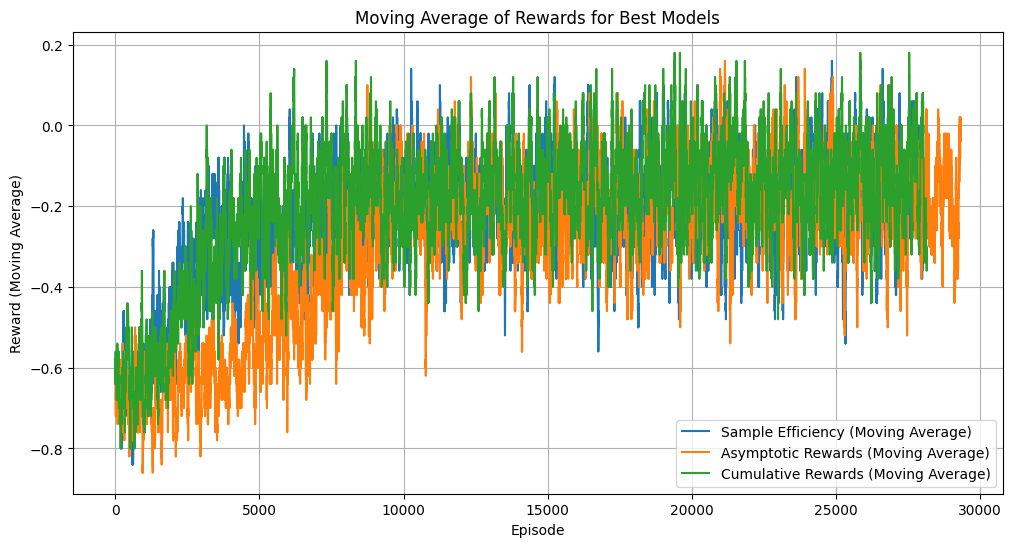

In [8]:
import matplotlib.pyplot as plt

# Function to calculate moving average
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Re-train the best models to gather their episode rewards
def train_best_model(params):
    callback = CustomLoggingCallback()

    model = DQN(
        "MlpPolicy",
        true_env,
        buffer_size=params["buffer_size"],
        batch_size=params["batch_size"],
        train_freq=params["train_freq"],
        gradient_steps=params["gradient_steps"],
        exploration_fraction=params["exploration_fraction"],
        exploration_final_eps=params["exploration_final_eps"],
        target_update_interval=params["target_update_interval"],
        learning_rate=1e-4,
        gamma=0.99,
        verbose=0,
    )

    model.learn(total_timesteps=200000, callback=callback)
    episode_rewards = [np.sum(episode.rewards) for episode in callback.episodes]
    return episode_rewards

# Train and collect rewards for the three best models
best_models = {
    "Sample Efficiency": best_sample_efficiency,
    "Asymptotic Rewards": best_asymptotic_rewards,
    "Cumulative Rewards": best_cumulative_rewards,
}

rewards_data = {}

for model_name, params in best_models.items():
    rewards_data[model_name] = train_best_model(params)

# Plot moving averages of the rewards
plt.figure(figsize=(12, 6))
for model_name, rewards in rewards_data.items():
    moving_avg = moving_average(rewards, window_size=50)
    plt.plot(moving_avg, label=f"{model_name} (Moving Average)")

plt.title("Moving Average of Rewards for Best Models")
plt.xlabel("Episode")
plt.ylabel("Reward (Moving Average)")
plt.legend()
plt.grid()
plt.show()


In [12]:
rewards_data["Sample Efficiency"]

[-1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.

In [11]:
import json

# Prepare the data for JSON
sample_eff_data = {
    "name": "DQN-Sample-Eff",
    "info": {
        "description": "DQN model optimized for sample efficiency.",
        "params": best_sample_efficiency
    },
    "mean_rewards": []
}


# Save the data to a JSON file
with open("json/dqn/sample_eff.json", "w") as f:
    json.dump(sample_eff_data, f, indent=4)


TypeError: Object of type float32 is not JSON serializable

In [4]:
def moving_avg(data, window_size):
    half_window = window_size // 2

    # Pad the data with the edge values to handle borders
    padded_data = np.concatenate((data[:half_window], data, data[-half_window:]))

    # Compute the moving average using a sliding window
    smoothed = [np.mean(padded_data[i:i+window_size]) for i in range(len(data))]

    return smoothed

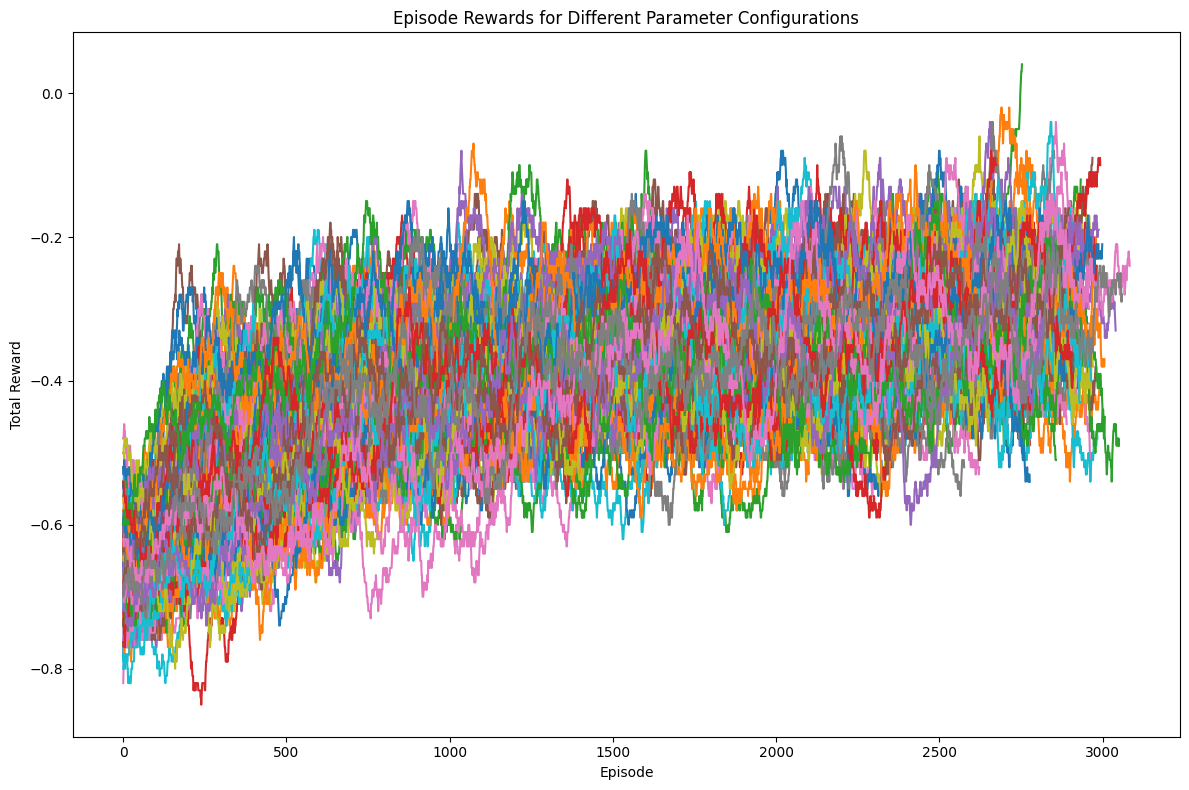

In [7]:
# Plot rewards for each configuration
plt.figure(figsize=(12, 8))
for params, rewards in results:
    smoothed = moving_avg(rewards, 100)
    plt.plot(range(len(rewards)), smoothed, label=str(params))

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Rewards for Different Parameter Configurations")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:

# Plot rewards for each configuration
plt.figure(figsize=(12, 8))
for params, rewards in all_rewards:
    plt.plot(range(len(rewards)), rewards, label=str(params))

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Rewards for Different Parameter Configurations")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()